### Code 1 -- uncertainty just with mean of STD

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, optimizers, Input
from datetime import timedelta
import tensorflow as tf
# --- Load datasets ---
df_Train = pd.read_excel("X_train_scaled.xlsx")
df_Val = pd.read_excel("X_val_scaled.xlsx")
df_Test = pd.read_excel("X_test_scaled.xlsx")

# --- Load holiday and weekend dataset ---
holidays_df = pd.read_excel("3.Holydays .xlsx")
holidays_df['DateKEY'] = pd.to_datetime(holidays_df['DateKEY'], format='%Y%m%d')

# --- Selected features ---
selected_features = [
    'air_temperature', 'diffuse_r', 'elspot', 'full_solar', 'global_r',
    'gust_speed', 'relative_humidity', 'sunshine', 'wind_speed', 'hour', 'weekday',
    'is_weekend', 'is_holiday', 'is_long_holiday', 'avg_temperature'
]

# --- Prepare the weekend and holiday feature ---
def create_weekend_holiday_feature(df, holidays_df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['is_weekend'] = df['datetime'].dt.weekday.isin([5, 6]).astype(int)
    df['is_holiday'] = df['datetime'].dt.date.isin(holidays_df['DateKEY'].dt.date).astype(int)
    df['is_long_holiday'] = df['is_holiday'].rolling(window=7).sum().ffill()
    if 'air_temperature' in df.columns:
        df['avg_temperature'] = df['air_temperature'].rolling(window=7).mean().ffill()
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    df[selected_features] = df[selected_features].fillna(df[selected_features].mean())
    return df

# --- Apply to all datasets ---
df_Train = create_weekend_holiday_feature(df_Train, holidays_df)
df_Val = create_weekend_holiday_feature(df_Val, holidays_df)
df_Test = create_weekend_holiday_feature(df_Test, holidays_df)

# --- Normalize data ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_full = df_Train[selected_features].values
y_train_full = df_Train['energy'].values.reshape(-1, 1)
X_val_full = df_Val[selected_features].values
y_val_full = df_Val['energy'].values.reshape(-1, 1)
X_test_full = df_Test[selected_features].values
y_test_full = df_Test['energy'].values.reshape(-1, 1)

X_train_full = scaler_X.fit_transform(X_train_full)
X_val_full = scaler_X.transform(X_val_full)
X_test_full = scaler_X.transform(X_test_full)
y_train_full = scaler_y.fit_transform(y_train_full)
y_val_full = scaler_y.transform(y_val_full)
y_test_full = scaler_y.transform(y_test_full)

# --- Sliding Window Function ---
def create_sliding_windows_with_holiday(X_full, y_full, window_size, timestamps):
    X, y = [], []
    for i in range(len(X_full) - window_size):
        X.append(X_full[i:i + window_size])
        y.append(y_full[i + window_size])
    return np.array(X), np.array(y)

# --- Set window size ---
window_size = 168  # 7 days (hours)

# --- Create sliding windows ---
X_train, y_train = create_sliding_windows_with_holiday(X_train_full, y_train_full, window_size, df_Train['datetime'])
X_val, y_val = create_sliding_windows_with_holiday(X_val_full, y_val_full, window_size, df_Val['datetime'])
X_test, y_test = create_sliding_windows_with_holiday(X_test_full, y_test_full, window_size, df_Test['datetime'])
time_test = pd.Series(pd.to_datetime(df_Test['datetime'])[window_size:])

# --- Reshape for LSTM ---
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(selected_features)))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(selected_features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(selected_features)))
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

# --- NLL Loss Function ---
@tf.function
def nll_loss(y_true, y_pred):
    mu = y_pred[:, 0]
    log_var = y_pred[:, 1]
    var = tf.nn.softplus(log_var) + 1e-3
    return tf.reduce_mean(0.5 * (tf.math.log(var) + tf.square(y_true - mu) / var))

# --- LSTM Model with MC-Dropout ---
def build_lstm_with_dropout(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.LSTM(50, return_sequences=False, dropout=0.3)(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(20, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, kernel_initializer='glorot_normal')(x)
    model = models.Model(inputs, outputs)
    optimizer = optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=nll_loss)
    return model

# --- Train Ensemble of LSTM Models ---
ensemble_models = []
n_ensemble = 5
epochs = 30
for _ in range(n_ensemble):
    model = build_lstm_with_dropout((window_size, len(selected_features)))
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    ensemble_models.append(model)

# --- MC Dropout Prediction with Uncertainty ---
def mc_dropout_predict(model, X, n_iter=20):
    predictions = np.array([model(X, training=True).numpy() for _ in range(n_iter)])
    mean_mu = predictions[:, :, 0].mean(axis=0)
    mean_log_var = predictions[:, :, 1].mean(axis=0)
    var = tf.nn.softplus(mean_log_var) + 1e-3
    std = np.sqrt(var.numpy())
    return mean_mu, std

# --- Get Ensemble Predictions ---
ensemble_preds = [mc_dropout_predict(model, X_test, n_iter=20) for model in ensemble_models]
mean_pred = np.mean([pred[0] for pred in ensemble_preds], axis=0)
std_pred = np.mean([pred[1] for pred in ensemble_preds], axis=0)

# --- Inverse transform predictions ---
mean_pred = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
std_pred = std_pred * scaler_y.scale_[0]

# --- Evaluation ---
mae = mean_absolute_error(y_test, mean_pred)
rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
nll = np.mean([
    nll_loss(
        tf.convert_to_tensor(y_test.reshape(-1, 1), dtype=tf.float32),
        tf.convert_to_tensor(np.column_stack((mean_pred, np.log(std_pred**2 + 1e-3))), dtype=tf.float32)
    ).numpy() for _ in ensemble_models
])

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ NLL: {nll:.2f}")

# --- Plot Forecast for 1 Week ---
week_indices = (time_test >= time_test.iloc[0]) & (time_test < time_test.iloc[0] + timedelta(weeks=1))
time_week = time_test[week_indices]
true_week = y_test[week_indices]
mean_week = mean_pred[week_indices]
std_week = std_pred[week_indices]

plt.figure(figsize=(15, 5))
plt.plot(time_week, true_week, label="True Energy", alpha=0.6)
plt.plot(time_week, mean_week, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_week, mean_week - 1.96 * std_week, mean_week + 1.96 * std_week,
                 color='orange', alpha=0.3, label="95% CI")
plt.title("Forecast for 1 Week (Deep Ensemble LSTM with Dropout)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Forecasts Over Multiple Time Spans ---
time_spans = {
    '1 Day': timedelta(days=1),
    '1 Week': timedelta(weeks=1),
    '1 Month': timedelta(days=30),
    '3 Months': timedelta(days=90),
    '6 Months': timedelta(days=180),
    '1 Year': timedelta(days=365),
    'Full Range': time_test.iloc[-1] - time_test.iloc[0]
}

for label, delta in time_spans.items():
    start_time = time_test.iloc[0]
    end_time = start_time + delta
    mask = (time_test >= start_time) & (time_test <= end_time)
    if mask.sum() == 0:
        continue

    time_range = time_test[mask]
    true_values = y_test[mask]
    mean_values = mean_pred[mask]
    std_values = std_pred[mask]

    plt.figure(figsize=(15, 5))
    plt.plot(time_range, true_values, label="True Energy", alpha=0.6)
    plt.plot(time_range, mean_values, label="Predicted Mean", alpha=0.9)
    plt.fill_between(time_range, mean_values - 1.96 * std_values, mean_values + 1.96 * std_values,
                     color='orange', alpha=0.3, label="95% CI")
    plt.title(f"Forecast for {label} (Deep Ensemble LSTM with Dropout)")
    plt.xlabel("Datetime")
    plt.ylabel("Energy")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Code 2 -- with epistemic + aleatoric variance

Epoch 1/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - loss: 0.4059 - val_loss: 0.0077
Epoch 2/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - loss: 0.0543 - val_loss: 0.0115
Epoch 3/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - loss: 0.0034 - val_loss: -0.1139
Epoch 4/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - loss: -0.0808 - val_loss: -0.1883
Epoch 5/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - loss: -0.1122 - val_loss: -0.2017
Epoch 6/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - loss: -0.1711 - val_loss: -0.2434
Epoch 7/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - loss: -0.1878 - val_loss: -0.2983
Epoch 8/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - loss: -0.2287 - val_loss: -0.2874
Epoch 9/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - loss: -0.2133 - val_loss: -0.2842
Epoch 10/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - loss: -0.2323 - val_loss: -0.3118
Epoch 11/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - loss: -0.2553 - val_loss: -0.2850
Epoch 12/30
3

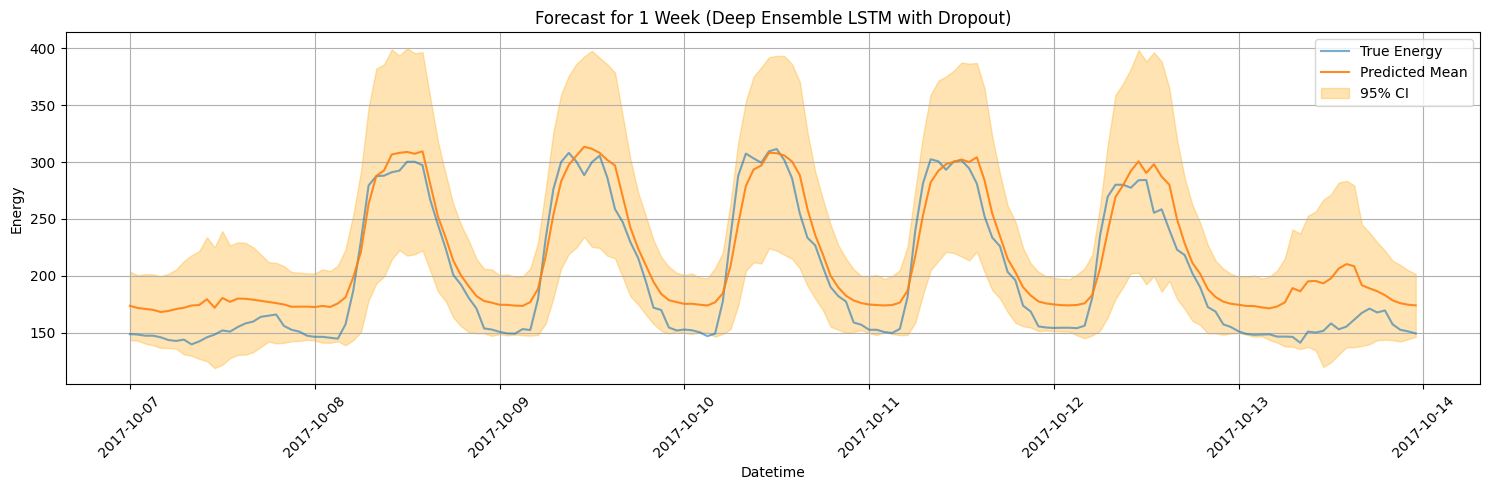

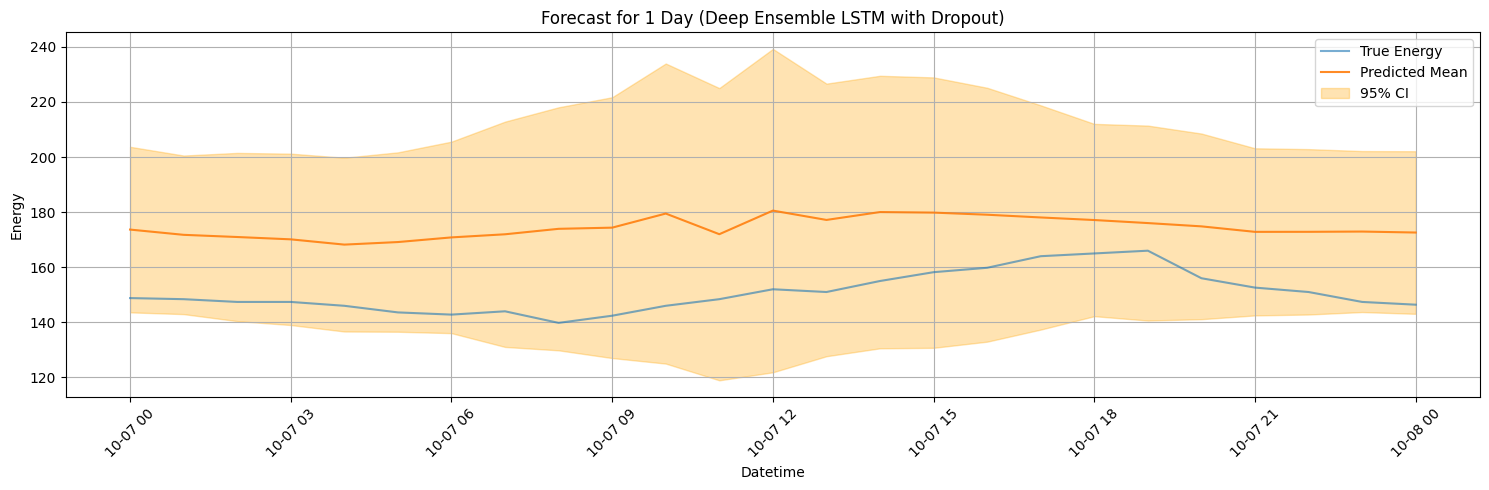

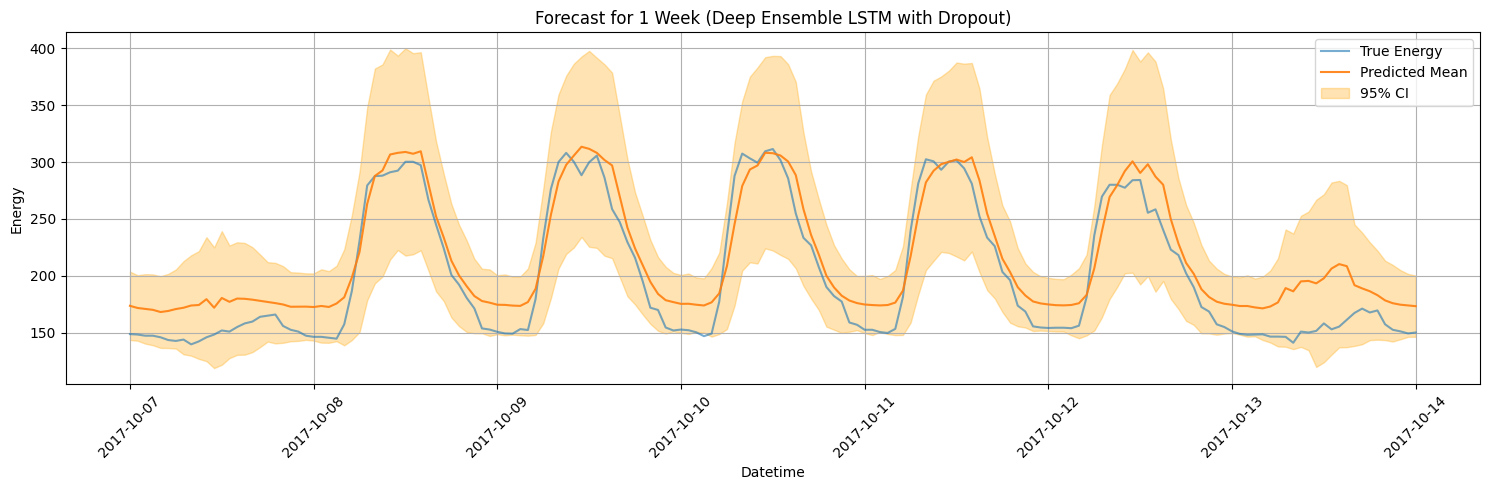

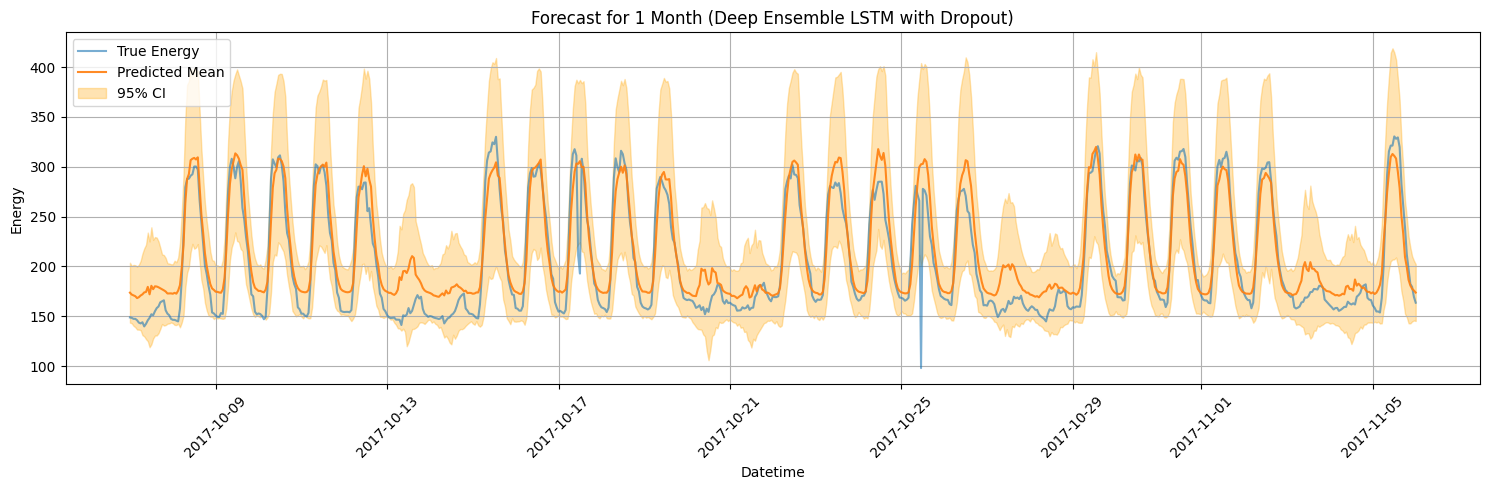

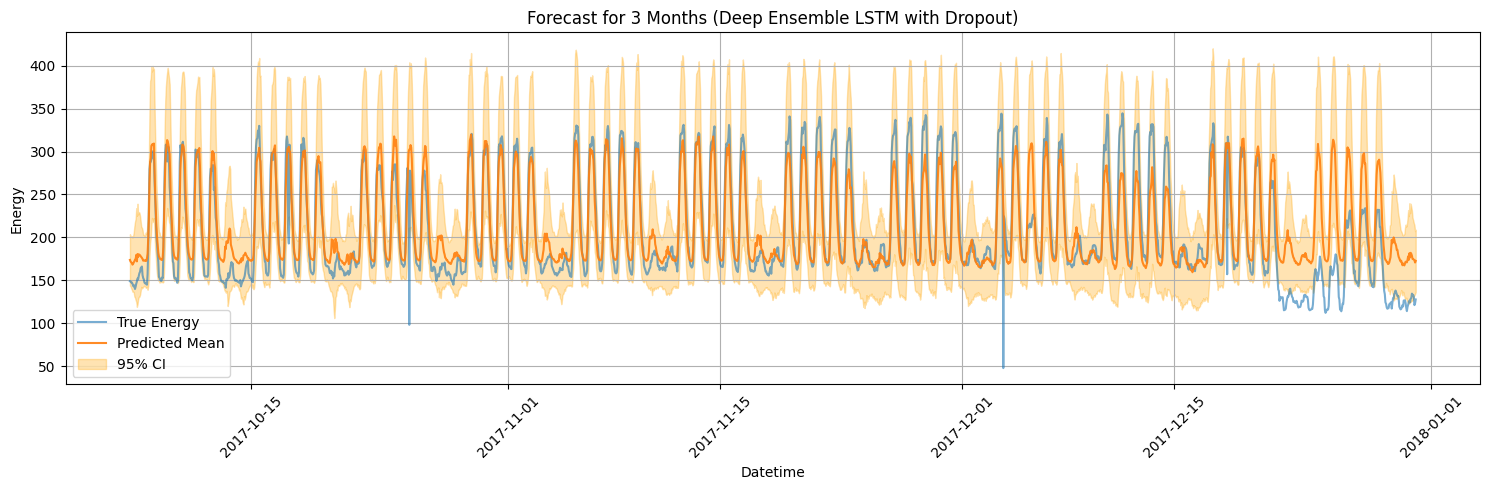

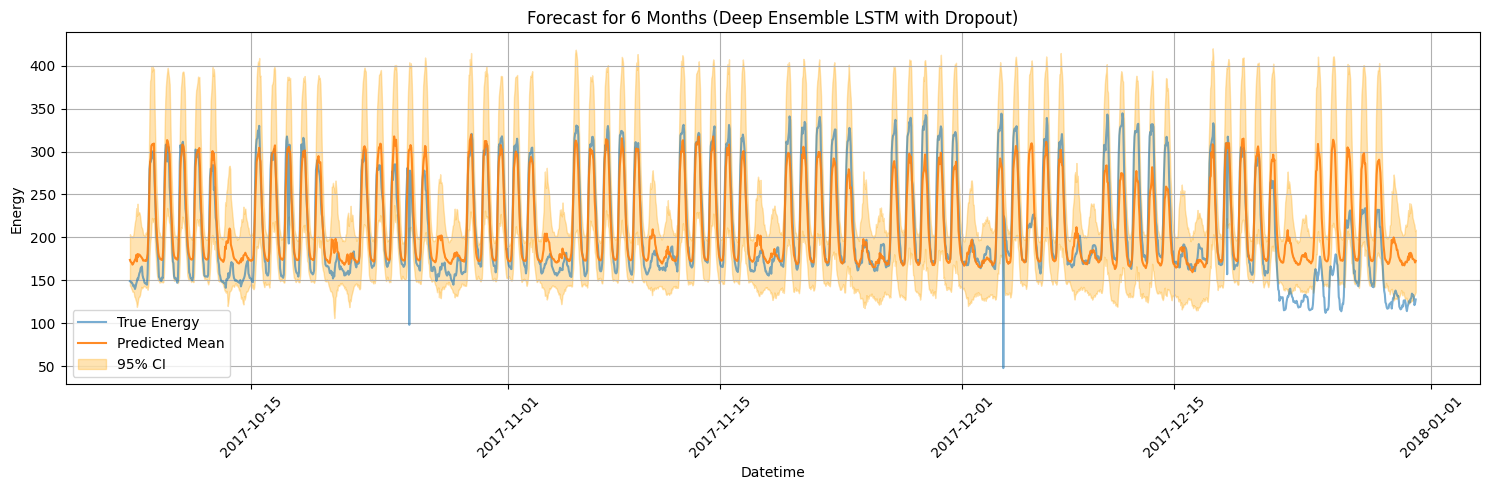

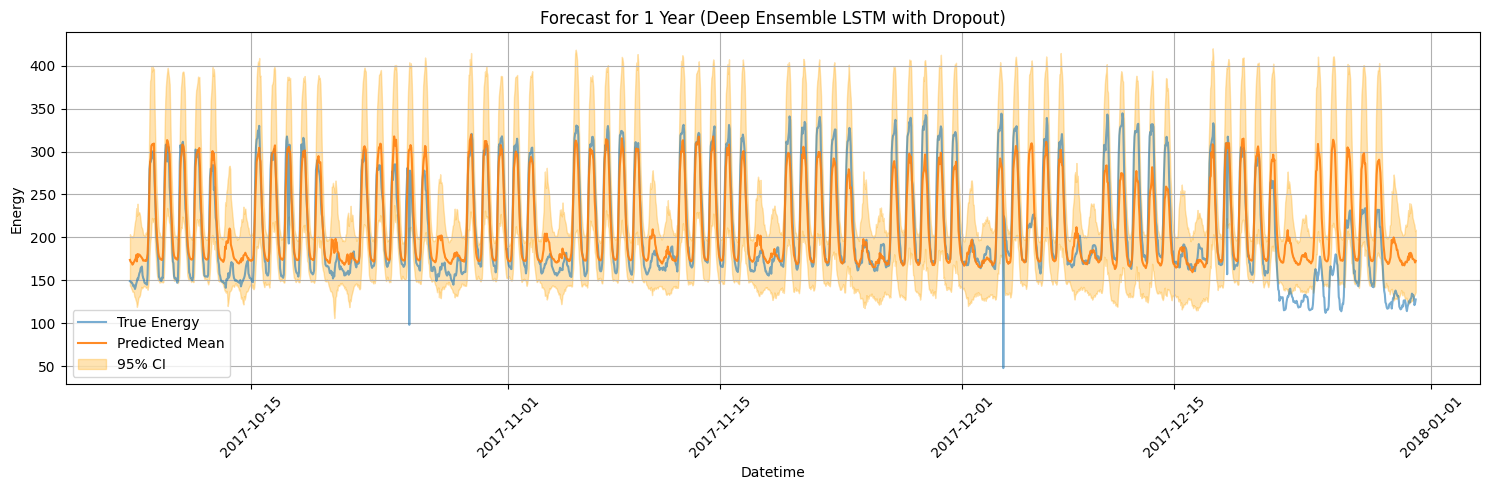

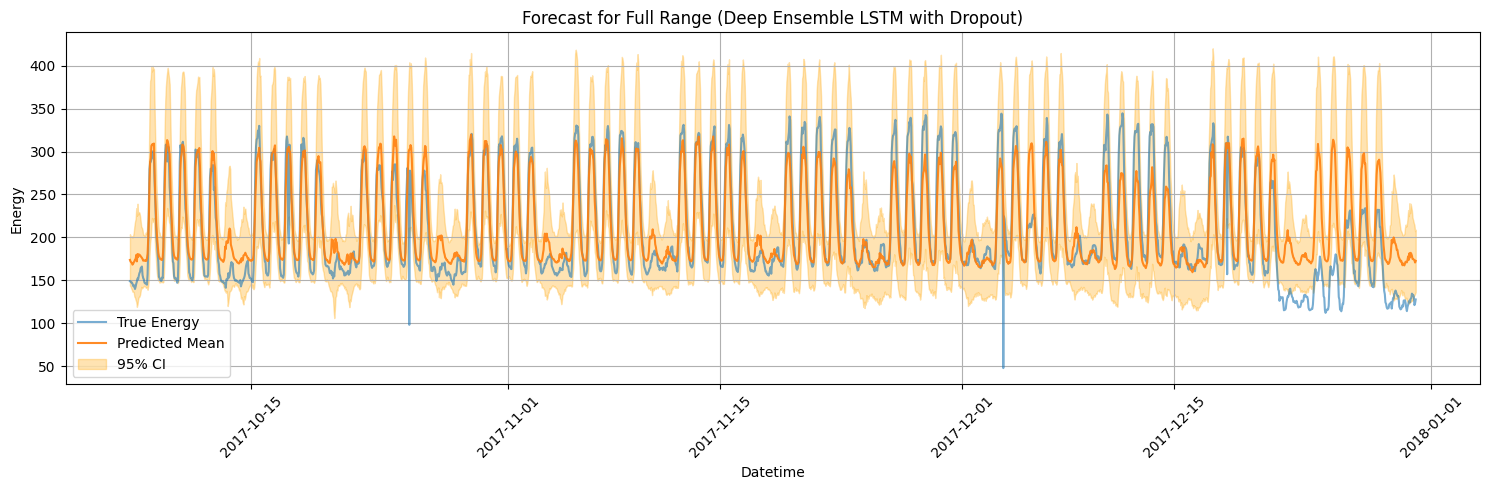

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, optimizers, Input
from datetime import timedelta
import tensorflow as tf

# --- Load datasets ---
df_Train = pd.read_excel("X_train_scaled.xlsx")
df_Val = pd.read_excel("X_val_scaled.xlsx")
df_Test = pd.read_excel("X_test_scaled.xlsx")

# --- Load holiday and weekend dataset ---
holidays_df = pd.read_excel("3.Holydays .xlsx")
holidays_df['DateKEY'] = pd.to_datetime(holidays_df['DateKEY'], format='%Y%m%d')

# --- Selected features ---
selected_features = [
    'air_temperature', 'diffuse_r', 'elspot', 'full_solar', 'global_r',
    'gust_speed', 'relative_humidity', 'sunshine', 'wind_speed', 'hour', 'weekday',
    'is_weekend', 'is_holiday', 'is_long_holiday', 'avg_temperature'
]

# --- Prepare the weekend and holiday feature ---
def create_weekend_holiday_feature(df, holidays_df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['is_weekend'] = df['datetime'].dt.weekday.isin([5, 6]).astype(int)
    df['is_holiday'] = df['datetime'].dt.date.isin(holidays_df['DateKEY'].dt.date).astype(int)
    df['is_long_holiday'] = df['is_holiday'].rolling(window=7).sum().ffill()
    if 'air_temperature' in df.columns:
        df['avg_temperature'] = df['air_temperature'].rolling(window=7).mean().ffill()
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    df[selected_features] = df[selected_features].fillna(df[selected_features].mean())
    return df

# --- Apply to all datasets ---
df_Train = create_weekend_holiday_feature(df_Train, holidays_df)
df_Val = create_weekend_holiday_feature(df_Val, holidays_df)
df_Test = create_weekend_holiday_feature(df_Test, holidays_df)

# --- Normalize data ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_full = df_Train[selected_features].values
y_train_full = df_Train['energy'].values.reshape(-1, 1)
X_val_full = df_Val[selected_features].values
y_val_full = df_Val['energy'].values.reshape(-1, 1)
X_test_full = df_Test[selected_features].values
y_test_full = df_Test['energy'].values.reshape(-1, 1)

X_train_full = scaler_X.fit_transform(X_train_full)
X_val_full = scaler_X.transform(X_val_full)
X_test_full = scaler_X.transform(X_test_full)
y_train_full = scaler_y.fit_transform(y_train_full)
y_val_full = scaler_y.transform(y_val_full)
y_test_full = scaler_y.transform(y_test_full)

# --- Sliding Window Function ---
def create_sliding_windows_with_holiday(X_full, y_full, window_size, timestamps):
    X, y = [], []
    for i in range(len(X_full) - window_size):
        X.append(X_full[i:i + window_size])
        y.append(y_full[i + window_size])
    return np.array(X), np.array(y)

# --- Set window size ---
window_size = 168  # 7 days (hours)

# --- Create sliding windows ---
X_train, y_train = create_sliding_windows_with_holiday(X_train_full, y_train_full, window_size, df_Train['datetime'])
X_val, y_val = create_sliding_windows_with_holiday(X_val_full, y_val_full, window_size, df_Val['datetime'])
X_test, y_test = create_sliding_windows_with_holiday(X_test_full, y_test_full, window_size, df_Test['datetime'])
time_test = pd.Series(pd.to_datetime(df_Test['datetime'])[window_size:])

# --- Reshape for LSTM ---
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(selected_features)))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(selected_features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(selected_features)))
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

# --- NLL Loss Function ---
@tf.function
def nll_loss(y_true, y_pred):
    mu = y_pred[:, 0]
    log_var = y_pred[:, 1]
    var = tf.nn.softplus(log_var) + 1e-3
    return tf.reduce_mean(0.5 * (tf.math.log(var) + tf.square(y_true - mu) / var))

# --- LSTM Model with MC-Dropout ---
def build_lstm_with_dropout(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.LSTM(50, return_sequences=False, dropout=0.3)(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(20, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, kernel_initializer='glorot_normal')(x)
    model = models.Model(inputs, outputs)
    optimizer = optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=nll_loss)
    return model

# --- Train Ensemble of LSTM Models ---
ensemble_models = []
n_ensemble = 5
epochs = 30
for _ in range(n_ensemble):
    model = build_lstm_with_dropout((window_size, len(selected_features)))
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    ensemble_models.append(model)

# --- MC Dropout Prediction with Uncertainty ---
def mc_dropout_predict(model, X, n_iter=20):
    predictions = np.array([model(X, training=True).numpy() for _ in range(n_iter)])
    mean_mu = predictions[:, :, 0].mean(axis=0)
    mean_log_var = predictions[:, :, 1].mean(axis=0)
    var = tf.nn.softplus(mean_log_var) + 1e-3
    std = np.sqrt(var.numpy())
    return mean_mu, std

# --- Get Ensemble Predictions (Improved) ---
ensemble_means = []
ensemble_vars = []
for model in ensemble_models:
    mu, std = mc_dropout_predict(model, X_test, n_iter=20)
    ensemble_means.append(mu)
    ensemble_vars.append(std ** 2)

ensemble_means = np.array(ensemble_means)
ensemble_vars = np.array(ensemble_vars)
mean_pred = np.mean(ensemble_means, axis=0)
total_var = np.mean(ensemble_vars, axis=0) + np.var(ensemble_means, axis=0)
std_pred = np.sqrt(total_var)

# --- Inverse transform predictions ---
mean_pred = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
std_pred = std_pred * scaler_y.scale_[0]

# --- Evaluation ---
mae = mean_absolute_error(y_test, mean_pred)
rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
nll = np.mean([
    nll_loss(
        tf.convert_to_tensor(y_test.reshape(-1, 1), dtype=tf.float32),
        tf.convert_to_tensor(np.column_stack((mean_pred, np.log(std_pred**2 + 1e-3))), dtype=tf.float32)
    ).numpy() for _ in ensemble_models
])

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ NLL: {nll:.2f}")

# --- Plot Forecast for 1 Week ---
week_indices = (time_test >= time_test.iloc[0]) & (time_test < time_test.iloc[0] + timedelta(weeks=1))
time_week = time_test[week_indices]
true_week = y_test[week_indices]
mean_week = mean_pred[week_indices]
std_week = std_pred[week_indices]

plt.figure(figsize=(15, 5))
plt.plot(time_week, true_week, label="True Energy", alpha=0.6)
plt.plot(time_week, mean_week, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_week, mean_week - 1.96 * std_week, mean_week + 1.96 * std_week,
                 color='orange', alpha=0.3, label="95% CI")
plt.title("Forecast for 1 Week (Deep Ensemble LSTM with Dropout)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Forecasts Over Multiple Time Spans ---
time_spans = {
    '1 Day': timedelta(days=1),
    '1 Week': timedelta(weeks=1),
    '1 Month': timedelta(days=30),
    '3 Months': timedelta(days=90),
    '6 Months': timedelta(days=180),
    '1 Year': timedelta(days=365),
    'Full Range': time_test.iloc[-1] - time_test.iloc[0]
}

for label, delta in time_spans.items():
    start_time = time_test.iloc[0]
    end_time = start_time + delta
    mask = (time_test >= start_time) & (time_test <= end_time)
    if mask.sum() == 0:
        continue

    time_range = time_test[mask]
    true_values = y_test[mask]
    mean_values = mean_pred[mask]
    std_values = std_pred[mask]

    plt.figure(figsize=(15, 5))
    plt.plot(time_range, true_values, label="True Energy", alpha=0.6)
    plt.plot(time_range, mean_values, label="Predicted Mean", alpha=0.9)
    plt.fill_between(time_range, mean_values - 1.96 * std_values, mean_values + 1.96 * std_values,
                     color='orange', alpha=0.3, label="95% CI")
    plt.title(f"Forecast for {label} (Deep Ensemble LSTM with Dropout)")
    plt.xlabel("Datetime")
    plt.ylabel("Energy")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
